In [1]:
%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
# importing all the necessary libraries .... importing library section

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score,classification_report,precision_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

import pickle
import re


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rawat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
from imblearn.over_sampling import SMOTE

In [4]:
%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [5]:
#Load the data

data = pd.read_csv(r"Data\amazon_alexa.tsv", delimiter = '\t', quoting = 3)

print(f"Dataset shape : {data.shape}")

Dataset shape : (3150, 5)


In [6]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [7]:
print(f"Feature names : {data.columns.values}")
#display all null values count with their column
data.isna().sum()

Feature names : ['rating' 'date' 'variation' 'verified_reviews' 'feedback']


rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [8]:
data[data['verified_reviews'].isna() == True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [9]:
# replace the original dataframe with no missing values
data.dropna(inplace=True)

In [10]:
print(f"Dataset shape after dropping null values : {data.shape}")

Dataset shape after dropping null values : (3149, 5)


In [11]:
data['length'] = data['verified_reviews'].apply(len)

In [12]:
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [13]:
#Distinct values of 'rating' and its count  

print(f"Rating value count: \n{data['rating'].value_counts()}")

Rating value count: 
rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64


In [14]:

print(f"Rating value count - percentage distribution: \n{round(data['rating'].value_counts()/data.shape[0]*100,2)}")

Rating value count - percentage distribution: 
rating
5    72.59
4    14.45
1     5.11
3     4.83
2     3.02
Name: count, dtype: float64


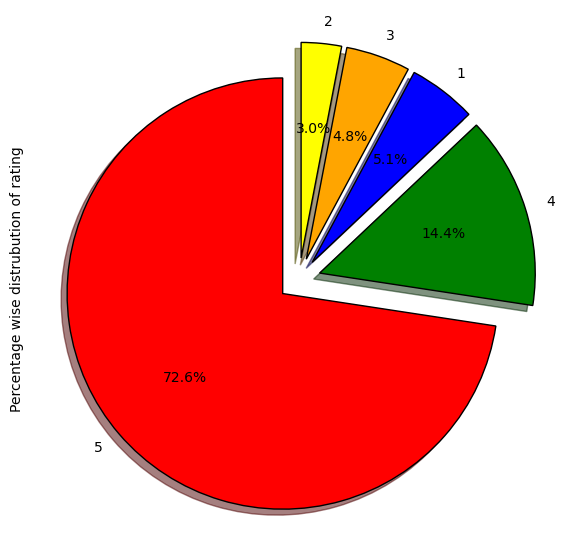

In [15]:
fig = plt.figure(figsize=(7,7))

colors = ('red', 'green', 'blue','orange','yellow')

wp = {'linewidth':1, "edgecolor":'black'}

tags = data['rating'].value_counts()/data.shape[0]

explode=(0.1,0.1,0.1,0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of rating')

from io import  BytesIO

graph = BytesIO()

fig.savefig(graph, format="png")

In [16]:
print(f"Feedback value count: \n{data['feedback'].value_counts()}")

Feedback value count: 
feedback
1    2893
0     256
Name: count, dtype: int64


In [17]:
print(f"Feedback value count - percentage distribution: \n{round(data['feedback'].value_counts()/data.shape[0]*100,2)}")

Feedback value count - percentage distribution: 
feedback
1    91.87
0     8.13
Name: count, dtype: float64


<Axes: ylabel='Percentage wise distrubution of feedback'>

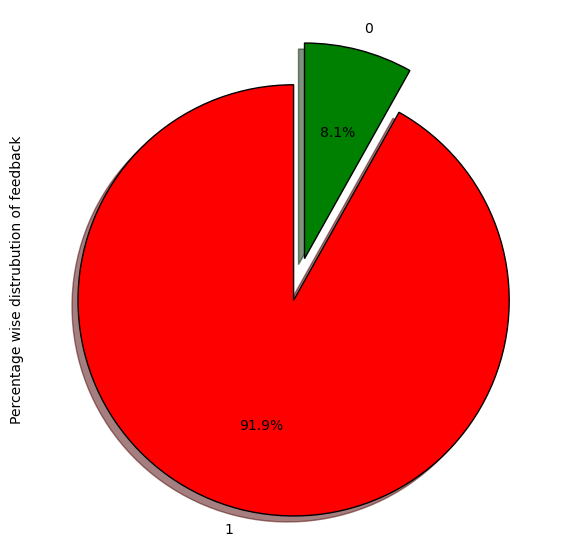

In [18]:
fig = plt.figure(figsize=(7,7))

colors = ('red', 'green')

wp = {'linewidth':1, "edgecolor":'black'}

tags = data['feedback'].value_counts()/data.shape[0]

explode=(0.1,0.1)

tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of feedback')

In [19]:
#Feedback = 0
data[data['feedback'] == 0]['rating'].value_counts()

rating
1    161
2     95
Name: count, dtype: int64

In [20]:
#Feedback = 1
data[data['feedback'] == 1]['rating'].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

[Text(0.5, 1.0, 'Distribution of length of review ')]

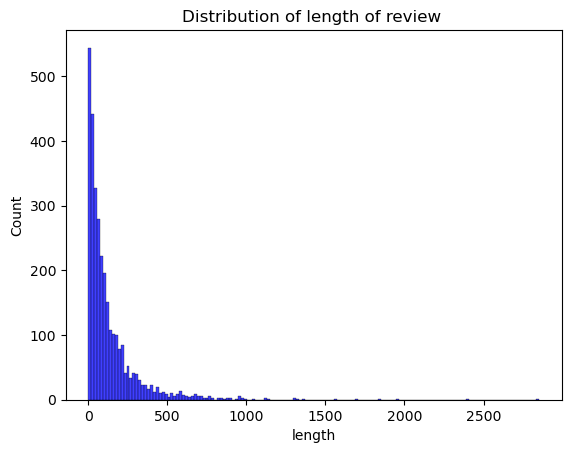

In [21]:
sns.histplot(data['length'],color='blue').set(title='Distribution of length of review ')

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 0')]

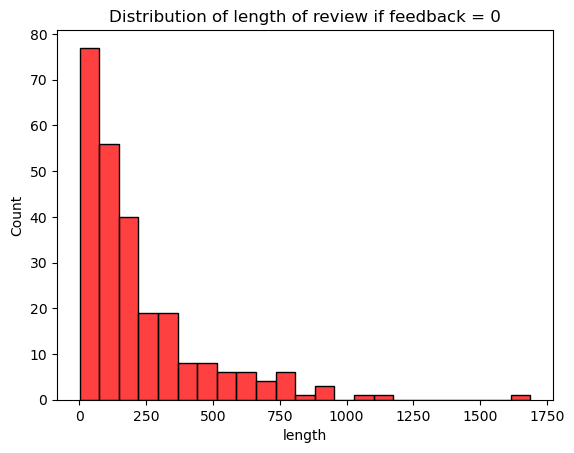

In [22]:
sns.histplot(data[data['feedback']==0]['length'],color='red').set(title='Distribution of length of review if feedback = 0')

[Text(0.5, 1.0, 'Distribution of length of review if feedback = 1')]

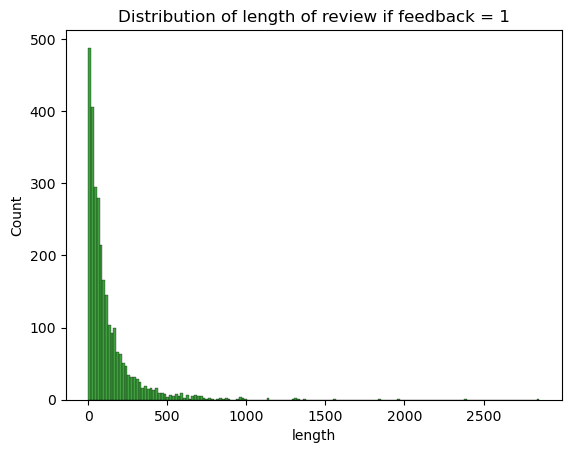

In [23]:
sns.histplot(data[data['feedback']==1]['length'],color='green').set(title='Distribution of length of review if feedback = 1')

In [24]:
# countVectorizer class tokenizes all reviews with no stopwords then fit and transforms them into "words" array. 
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data.verified_reviews)
print(words.shape)

(3149, 3784)


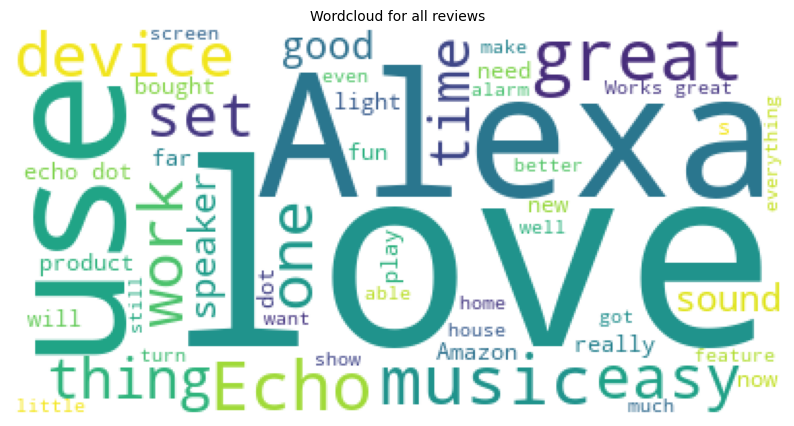

In [25]:
#Generation of a word cloud image with having top 50 most appearing words in larger display

# Combine all reviews
reviews = " ".join([review for review in data['verified_reviews']])
                        
# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

In [26]:
# Combine all reviews for each feedback category and splitting them into individual words 
neg_reviews = " ".join([review for review in data[data['feedback'] == 0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in data[data['feedback'] == 1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

#Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)


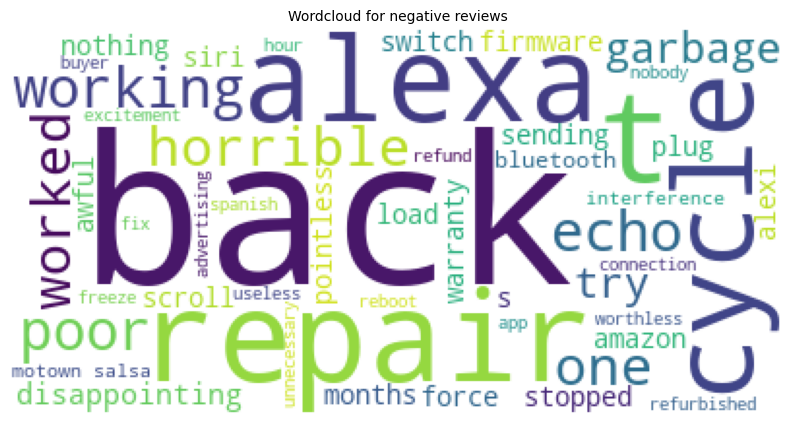

In [27]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

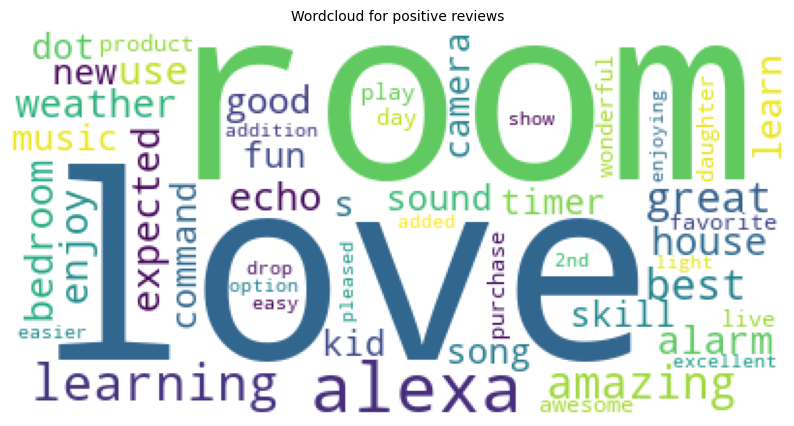

In [28]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

In [29]:
# stem every word in all reviews to it's base form and store them in the array corpus

corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['verified_reviews'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)


In [30]:
cv = CountVectorizer(max_features = 2500)

#Storing independent and dependent variables in X and y
X = cv.fit_transform(corpus).toarray()
y = data['feedback'].values


In [31]:
#Saving the Count Vectorizer
pickle.dump(cv, open('Models/countVectorizer.pkl', 'wb'))

In [32]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [33]:
print(f"X shape: {X_resampled.shape}")
print(f"y shape: {y_resampled.shape}")

X shape: (5786, 2500)
y shape: (5786,)


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.3, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (4050, 2500)
y train: (4050,)
X test: (1736, 2500)
y test: (1736,)


In [35]:
    print(f"X train max value: {X_train.max()}")
    print(f"X test max value: {X_test.max()}")

X train max value: 12
X test max value: 7


In [36]:
#scaling the data between 0 and 1 
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [37]:
pickle.dump(scaler, open('Models/scaler.pkl', 'wb'))

# RANDOM FOREST CLASSIFIER

In [38]:
#Fitting scaled X_train and y_train on Random Forest Classifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier()

In [74]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :",model_rf.score(X_train_scl, y_train)*100)
print("Testing Accuracy :", model_rf.score(X_test_scl, y_test)*100)

Training Accuracy : 98.76543209876543
Testing Accuracy : 94.23963133640552


In [40]:
y_preds_rf = model_rf.predict(X_test_scl)
print(f"accuracy score : {accuracy_score(y_test,y_preds_rf)*100}")
print(f"precision score : {precision_score(y_test,y_preds_rf)*100}")

print(classification_report(y_test,y_preds_rf))

accuracy score : 94.23963133640552
precision score : 96.74306393244873
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       861
           1       0.97      0.92      0.94       875

    accuracy                           0.94      1736
   macro avg       0.94      0.94      0.94      1736
weighted avg       0.94      0.94      0.94      1736



In [41]:
cm = confusion_matrix(y_test, y_preds_rf)

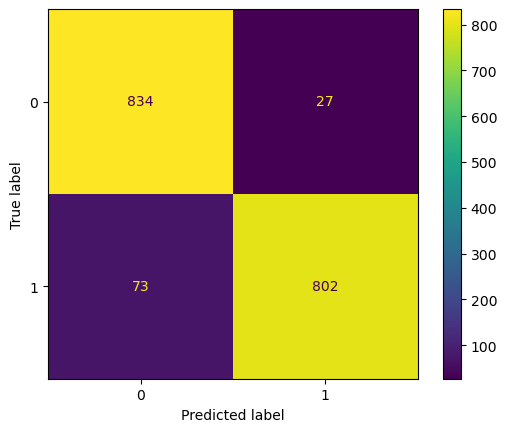

In [42]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

In [43]:
stratified_k_fold = StratifiedKFold(n_splits=10)

# Perform cross-validation with the stratified k-fold cross-validator
accuracies = cross_val_score(estimator=model_rf, X=X_train_scl, y=y_train, cv=stratified_k_fold)

print("Accuracy :", accuracies.mean() * 100)
print("Standard Variance :", accuracies.std())

Accuracy : 94.24691358024691
Standard Variance : 0.008556900469710355


In [44]:
# Hyper parameter tuning of random forest classifier

params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}

In [45]:
cv_object = StratifiedKFold(n_splits = 2)

grid_search = GridSearchCV(estimator = model_rf, param_grid = params, cv = cv_object, verbose = 0, return_train_score = True)
grid_search.fit(X_train_scl, y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [46]:
print("Best Parameter Combination : {}".format(grid_search.best_params_))

Best Parameter Combination : {'bootstrap': True, 'max_depth': 100, 'min_samples_split': 12, 'n_estimators': 100}


In [47]:
print(f"best accuracy : {grid_search.best_score_*100}")

best accuracy : 91.60493827160494


In [48]:
print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
y_preds = grid_search.best_estimator_.predict(X_test_scl)
print("Accuracy score for test set :", accuracy_score(y_test, y_preds)*100)

Cross validation mean accuracy on train set : 97.0895061728395
Cross validation mean accuracy on test set : 91.43518518518519
Accuracy score for test set : 92.97235023041475


In [49]:
pickle.dump(model_rf, open('Models/model_rf.pkl', 'wb'))

# XG BOOST CLASSIFIER

In [50]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [51]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_xgb.score(X_train_scl, y_train)*100)
print("Testing Accuracy :", model_xgb.score(X_test_scl, y_test)*100)

Training Accuracy : 94.81481481481482
Testing Accuracy : 91.64746543778803


In [52]:
y_preds_xgb = model_xgb.predict(X_test)

print(f"accuracy score : {accuracy_score(y_test,y_preds_xgb)*100}")
print(f"precision score : {precision_score(y_test,y_preds_xgb)*100}")

print(classification_report(y_test,y_preds_xgb))

accuracy score : 90.8410138248848
precision score : 97.6063829787234
              precision    recall  f1-score   support

           0       0.86      0.98      0.91       861
           1       0.98      0.84      0.90       875

    accuracy                           0.91      1736
   macro avg       0.92      0.91      0.91      1736
weighted avg       0.92      0.91      0.91      1736



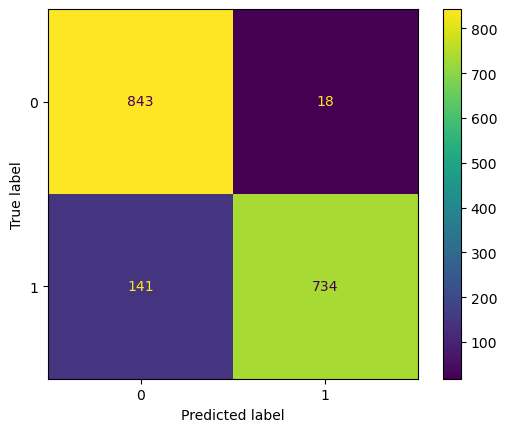

In [53]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds_xgb)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

In [54]:
stratified_k_fold = StratifiedKFold(n_splits=10)

# Perform cross-validation with the stratified k-fold cross-validator
accuracies = cross_val_score(estimator=model_xgb, X=X_train_scl, y=y_train, cv=stratified_k_fold)

print("Accuracy :", accuracies.mean() * 100)
print("Standard Variance :", accuracies.std())

Accuracy : 92.22222222222221
Standard Variance : 0.011056105272710176


In [55]:
params = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6, 9],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'n_estimators': [100, 200]
}

In [56]:
cv_object = StratifiedKFold(n_splits=5)
random_search = RandomizedSearchCV(estimator=model_xgb, param_distributions=params, n_iter=10, cv=cv_object, verbose=0, return_train_score=True, n_jobs=-1, random_state=42)
random_search.fit(X_train_scl, y_train.ravel())

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           impor...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 1.0],
                                        'learning_rate': [0.01, 0.1],
                                        'max_depth': [3, 6, 9],
                                        'min_child_weight': [1, 5, 10],
                                        'n_estimators': [100, 200],
                                        'subsample': [0.8, 1.0]},
                   random_state=42, return_train_score=True)

In [75]:
print("Best Parameters:", random_search.best_params_)

print("Best Cross-Validation Accuracy: {:.2f}%".format(random_search.best_score_ * 100))
mean_train_score = random_search.cv_results_['mean_train_score'].mean() * 100
print("Cross-validation mean accuracy on train set: {:.2f}%".format(mean_train_score))

mean_test_score = random_search.cv_results_['mean_test_score'].mean() * 100
print("Cross-validation mean accuracy on test set: {:.2f}%".format(mean_test_score))

y_preds = random_search.best_estimator_.predict(X_test_scl)

test_accuracy = accuracy_score(y_test, y_preds)
print("Accuracy score for test set: {:.2f}%".format(test_accuracy * 100))

Best Parameters: {'subsample': 0.8, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Best Cross-Validation Accuracy: 90.64%
Cross-validation mean accuracy on train set: 86.93%
Cross-validation mean accuracy on test set: 85.41%
Accuracy score for test set: 90.44%


In [58]:
#Saving the XGBoost classifier
pickle.dump(model_xgb, open('Models/model_xgb.pkl', 'wb'))

# DECISION TREE CLASSIFIER

In [59]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl, y_train)

DecisionTreeClassifier()

In [60]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_dt.score(X_train_scl, y_train)*100)
print("Testing Accuracy :", model_dt.score(X_test_scl, y_test)*100)

Training Accuracy : 98.76543209876543
Testing Accuracy : 92.97235023041475


In [61]:
y_preds_dt = model_dt.predict(X_test)
print(f"accuracy score : {accuracy_score(y_preds_dt,y_test)*100}")
print(f"precision score : {precision_score(y_preds_dt,y_test)*100}")
print(classification_report(y_preds_dt,y_test))

accuracy score : 91.76267281105991
precision score : 88.22857142857143
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       924
           1       0.88      0.95      0.92       812

    accuracy                           0.92      1736
   macro avg       0.92      0.92      0.92      1736
weighted avg       0.92      0.92      0.92      1736



In [62]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds_dt)
print(cm)

[[821  40]
 [103 772]]


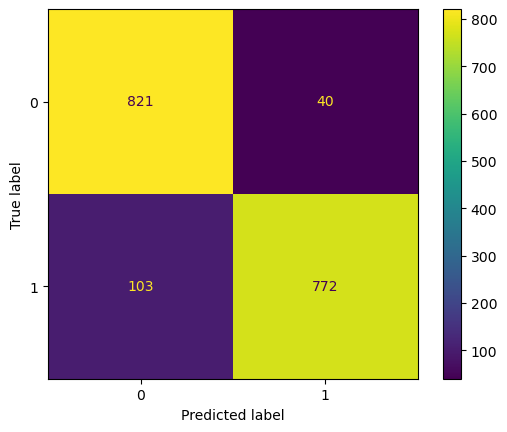

In [63]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_dt.classes_)
cm_display.plot()
plt.show()

In [64]:
stratified_k_fold = StratifiedKFold(n_splits=10)

# Perform cross-validation with the stratified k-fold cross-validator
accuracies = cross_val_score(estimator=model_dt, X=X_train_scl, y=y_train, cv=stratified_k_fold)

print("Accuracy :", accuracies.mean() * 100)
print("Standard Variance :", accuracies.std())

Accuracy : 92.74074074074076
Standard Variance : 0.007901234567901226


In [65]:
pickle.dump(model_dt, open('Models/model_dt.pkl', 'wb'))

# LOGISTIC REGRESSION CLASSIFIER

In [66]:
model_lr = LogisticRegression()
model_lr.fit(X_train_scl, y_train)

LogisticRegression()

In [67]:
#Accuracy of the model on training and testing data
print("Training Accuracy :", model_lr.score(X_train_scl, y_train)*100)
print("Testing Accuracy :", model_lr.score(X_test_scl, y_test)*100)

Training Accuracy : 94.19753086419753
Testing Accuracy : 90.49539170506912


In [68]:
y_preds_lr = model_lr.predict(X_test)
print(f"accuracy score : {accuracy_score(y_test,y_preds_lr)*100}")
print(f"precision score : {precision_score(y_test,y_preds_lr)*100}")
print(classification_report(y_test,y_preds_lr))

accuracy score : 89.91935483870968
precision score : 91.27358490566037
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       861
           1       0.91      0.88      0.90       875

    accuracy                           0.90      1736
   macro avg       0.90      0.90      0.90      1736
weighted avg       0.90      0.90      0.90      1736



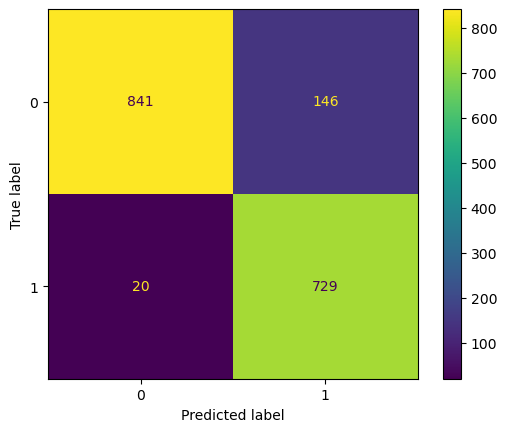

In [69]:
cm = confusion_matrix(y_preds,y_test)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_lr.classes_)
cm_display.plot()
plt.show()

In [70]:
stratified_k_fold = StratifiedKFold(n_splits=10)

# Perform cross-validation with the stratified k-fold cross-validator
accuracies = cross_val_score(estimator=model_lr, X=X_train_scl, y=y_train, cv=stratified_k_fold)

print("Accuracy :", accuracies.mean() * 100)
print("Standard Variance :", accuracies.std())

Accuracy : 90.37037037037037
Standard Variance : 0.009434554654095198


In [71]:
pickle.dump(model_rf,open('Models/model_lr.pkl','wb'))

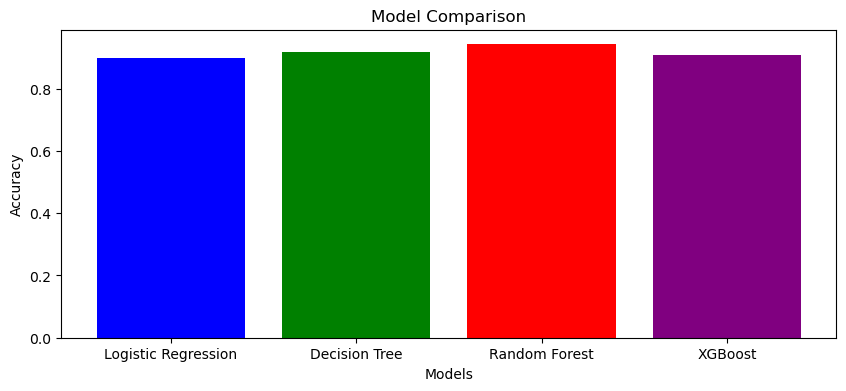

In [72]:
models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
accuracies = [accuracy_score(y_test, y_preds_lr), 
              accuracy_score(y_test, y_preds_dt), 
              accuracy_score(y_test, y_preds_rf), 
              accuracy_score(y_test, y_preds_xgb)]

# Plotting the accuracies
plt.figure(figsize=(10, 4))
plt.bar(models, accuracies, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.show()